## Train a classification model to determine to whom a handwritten signature belongs to.
- using classical computer vision

In [8]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np 
from glob import glob 
import argparse
from matplotlib import pyplot as plt 
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

In [9]:
label_count = 0 
train_labels = []
descriptor_list = []
category_dictionary = {}
sift = cv2.SIFT_create()
number_of_clusters = 5
cluster = KMeans(n_clusters=number_of_clusters,random_state=2001)
scaler = StandardScaler()
model = RandomForestClassifier(random_state=36)

def readImage(imageType):
    imagelist = {}
    image_count = 0
    for category in ['personA','personB','personC','personD','personE']:
        print("\nReading image category ", category,'\n' ,'-'*25)
        imagelist[category] = []
        for imagefile in os.listdir(category + '/' + imageType)[:-1]:
            print("Reading file ", imagefile)
            imagelist[category].append(cv2.imread(category + '/' + imageType + '/' + imagefile, 0))
            image_count += 1
    print('\nimage_count : ',image_count)
    return imagelist, image_count

def plotHist(mega_histogram):
    x_scalar = np.arange(number_of_clusters)
    y_scalar = np.array([abs(np.sum(mega_histogram[:, h], dtype=np.int32)) for h in range(number_of_clusters)])
    print("Vocabulary Histogram Generated")
    print(y_scalar)
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()
    

def reweight_tf_idf(histograms):
    re_hists  = np.zeros(histograms.shape)
    N = histograms.shape[0] # number of documents (images in the database)
    n_i = np.sum(histograms > 0, axis=0) # number of documents (images in the database) that contain the word i
    for hist_id in range(histograms.shape[0]):
        n_d  = np.sum(histograms[hist_id]) # total number of words in a document d
        for bin_id in range(len(histograms[hist_id])): 
            n_id = histograms[hist_id, bin_id] #occurance of word i in a document (image) d
            re_hists[hist_id, bin_id] = n_id/ n_d * np.log(N/n_i[bin_id]) if n_i[bin_id] > 0 else 0
            #print(re_hists[hist_id, bin_id], n_id, n_d, N, n_i[bin_id])
    return re_hists

# Train

In [10]:
# read file. prepare file lists.
train_imagelist, train_image_count = readImage('Train')


Reading image category  personA 
 -------------------------
Reading file  personA_1.png
Reading file  personA_11.png
Reading file  personA_12.png
Reading file  personA_14.png
Reading file  personA_15.png
Reading file  personA_16.png
Reading file  personA_17.png
Reading file  personA_18.png
Reading file  personA_19.png
Reading file  personA_21.png
Reading file  personA_22.png
Reading file  personA_23.png
Reading file  personA_24.png
Reading file  personA_25.png
Reading file  personA_26.png
Reading file  personA_28.png
Reading file  personA_3.png
Reading file  personA_31.png
Reading file  personA_32.png
Reading file  personA_33.png
Reading file  personA_34.png
Reading file  personA_35.png
Reading file  personA_36.png
Reading file  personA_37.png
Reading file  personA_38.png
Reading file  personA_39.png
Reading file  personA_4.png
Reading file  personA_40.png
Reading file  personA_41.png
Reading file  personA_43.png
Reading file  personA_44.png
Reading file  personA_45.png
Reading file  

In [11]:
# extract SIFT Features from each image
for category, imlist in train_imagelist.items():
    category_dictionary[str(label_count)] = category
    print ("Computing Features for ", category)
    for im in imlist:
        train_labels = np.append(train_labels, label_count)
        keypoints, descriptors = sift.detectAndCompute(im, None)
        descriptor_list.append(descriptors)
    label_count += 1

print('\ncategory_dictionary : ',category_dictionary)
print('\nlabel_count : ',label_count)
print('\ntrain_labels : ',train_labels)
print('\nfirst 3 in descriptor_list : ',descriptor_list[:3])

Computing Features for  personA
Computing Features for  personB
Computing Features for  personC
Computing Features for  personD
Computing Features for  personE

category_dictionary :  {'0': 'personA', '1': 'personB', '2': 'personC', '3': 'personD', '4': 'personE'}

label_count :  5

train_labels :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4.]

first 3 in descriptor_list :  [array([[0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., 

In [12]:
# stack descriptors
vStack = np.array(descriptor_list[0])
for remaining in descriptor_list[1:]:
    vStack = np.vstack((vStack, remaining))
descriptor_vstack = vStack.copy()
len(descriptor_list),len(descriptor_list[0]),descriptor_vstack.shape

(200, 267, (57872, 128))

In [13]:
# perform clustering
cluster_result = cluster.fit_predict(descriptor_vstack)
print("Clustering completed")

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
# developVocabulary
mega_histogram = np.array([np.zeros(number_of_clusters) for i in range(train_image_count)])
old_count = 0
for i in range(train_image_count):
    l = len(descriptor_list[i])
    for j in range(l):
        idx = cluster_result[old_count + j]
        mega_histogram[i][idx] += 1
    old_count += l

plotHist(mega_histogram) # show Vocabulary
mega_histogram[:3]

In [ ]:
#mega_histogram = reweight_tf_idf(mega_histogram)
#plotHist(mega_histogram)
#mega_histogram[:3]

In [ ]:
# normalization
mega_histogram_scaled = scaler.fit_transform(mega_histogram)
plotHist(mega_histogram_scaled) # show Vocabulary
mega_histogram_scaled[:3]

In [ ]:
# Training model
model.fit(mega_histogram_scaled, train_labels)
print("Training completed")

# Test

In [7]:
test_imagelist, test_image_count = readImage('Test') #read


Reading image category  personA 
 -------------------------
Reading file  personA_10.png
Reading file  personA_13.png
Reading file  personA_2.png
Reading file  personA_20.png
Reading file  personA_27.png
Reading file  personA_29.png
Reading file  personA_30.png
Reading file  personA_42.png

Reading image category  personB 
 -------------------------
Reading file  personB_10.png
Reading file  personB_13.png
Reading file  personB_2.png
Reading file  personB_20.png
Reading file  personB_27.png
Reading file  personB_29.png
Reading file  personB_33.png
Reading file  personB_42.png

Reading image category  personC 
 -------------------------
Reading file  personC_13.png
Reading file  personC_17.png
Reading file  personC_19.png
Reading file  personC_32.png
Reading file  personC_34.png
Reading file  personC_39.png
Reading file  personC_6.png
Reading file  personC_8.png

Reading image category  personD 
 -------------------------
Reading file  personD_14.png
Reading file  personD_15.png
Readin

In [8]:
predictions = []
correctClassifications = 0
for category, imlist in test_imagelist.items():
    print ("processing " ,category)
    for im in imlist:
        keypoints, descriptors = sift.detectAndCompute(im, None) #1- extract features
        cluster_result = cluster.predict(descriptors) #2- predict cluster
        
        #3- build vocabulary
        vocabulary = np.array([[ 0 for i in range(number_of_clusters)]],'float32') 
        for each in cluster_result:
            vocabulary[0][each] += 1
         
        #vocabulary = reweight_tf_idf(vocabulary) ### tf_idf 
        vocabulary = scaler.transform(vocabulary) #4- normalization
        result = model.predict(vocabulary) #5 - classification

        print (result)
        predictions.append({'image':im,'class':result,'object_name': category_dictionary[str(int(result[0]))]})

        if(category_dictionary[str(int(result[0]))]==category):
            correctClassifications = correctClassifications + 1
            
print(" Test Accuracy = " + str((correctClassifications/test_image_count) * 100))

processing  personA


AttributeError: 'KMeans' object has no attribute 'cluster_centers_'

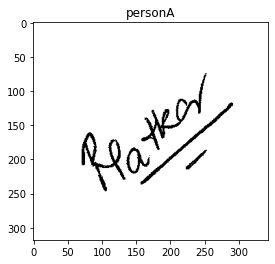

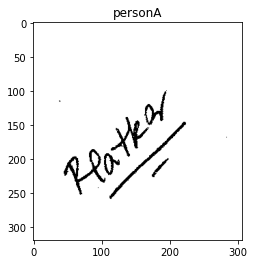

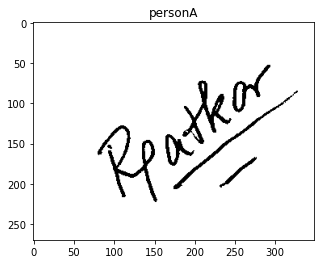

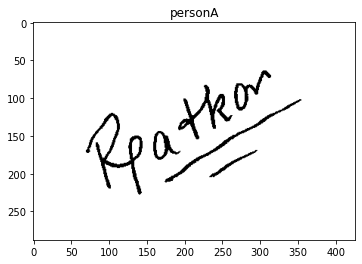

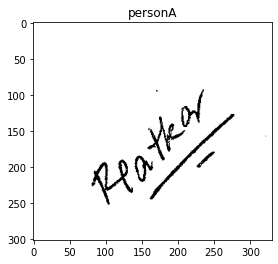

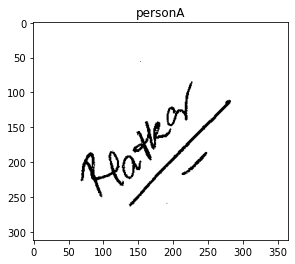

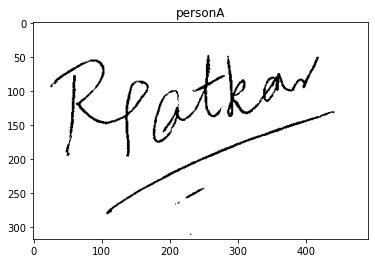

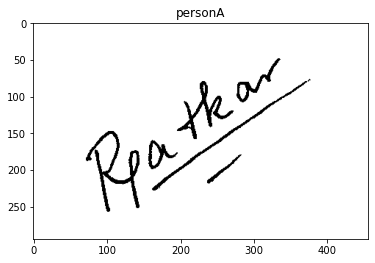

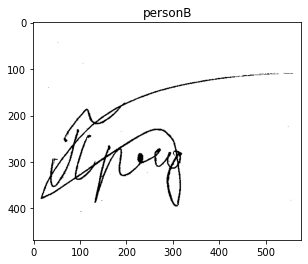

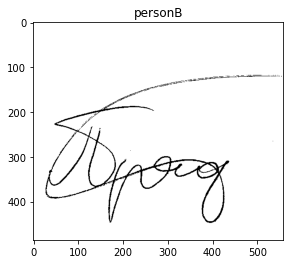

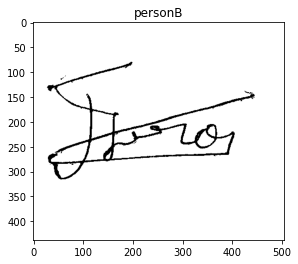

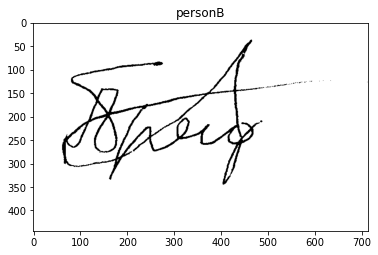

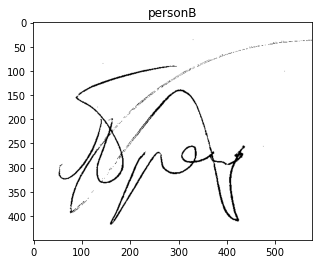

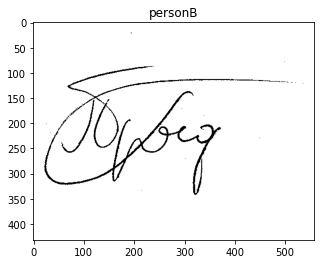

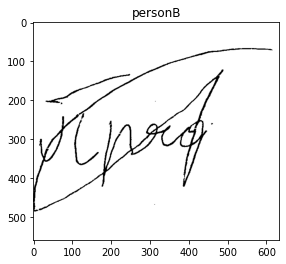

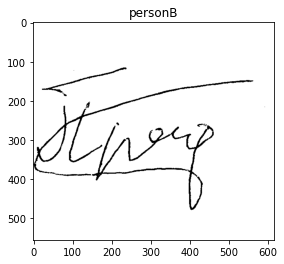

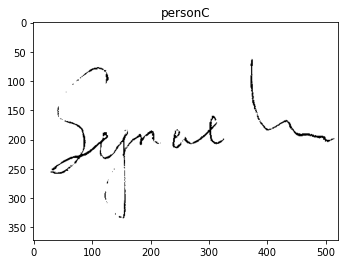

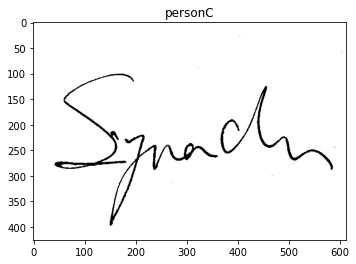

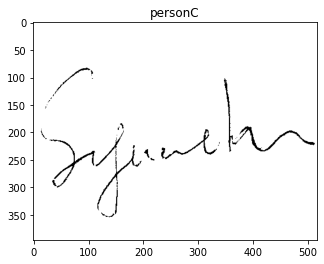

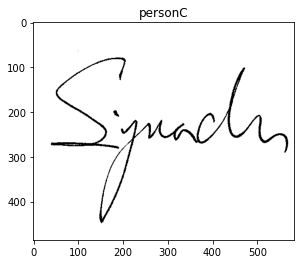

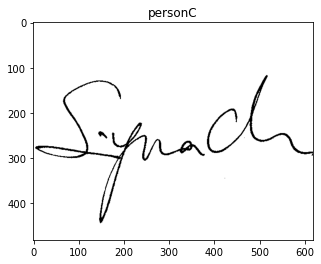

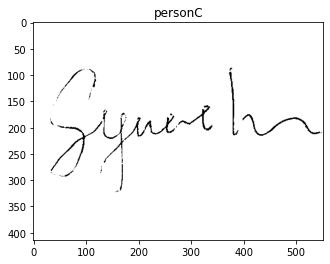

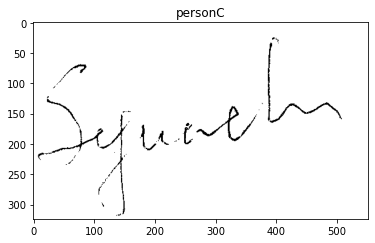

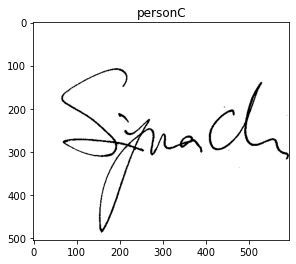

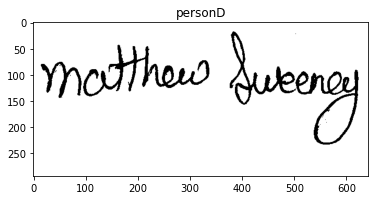

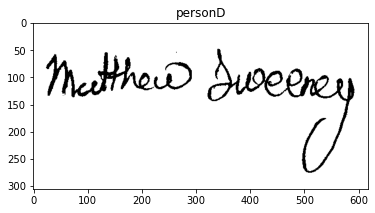

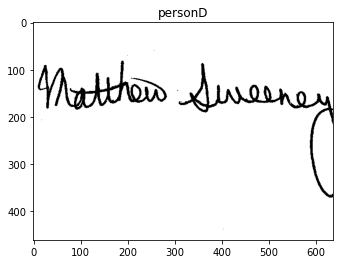

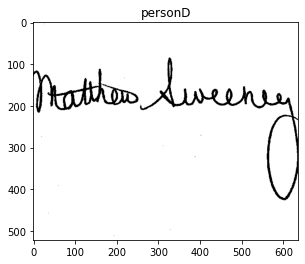

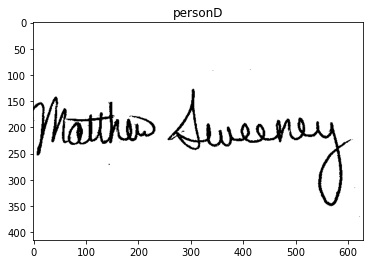

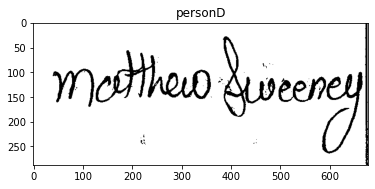

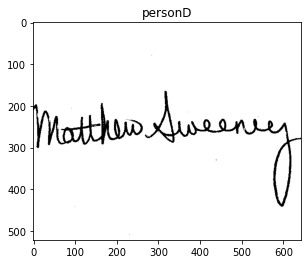

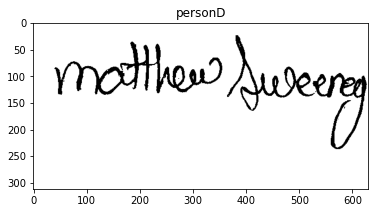

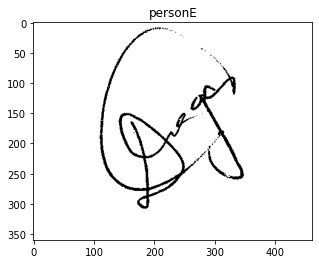

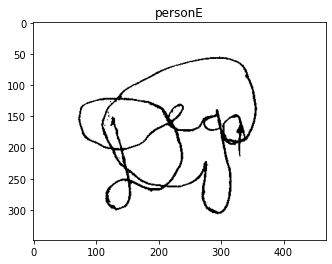

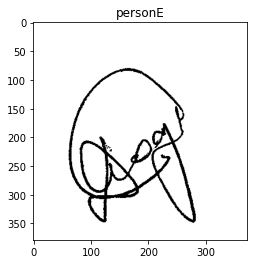

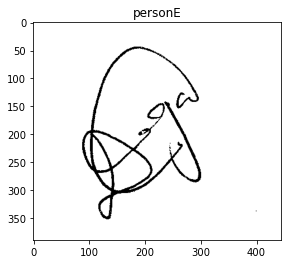

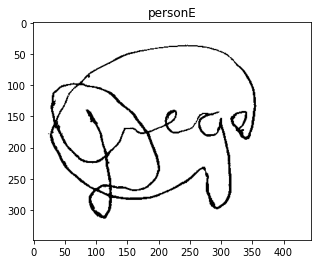

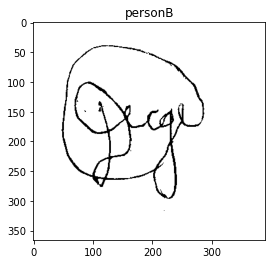

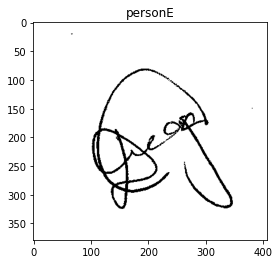

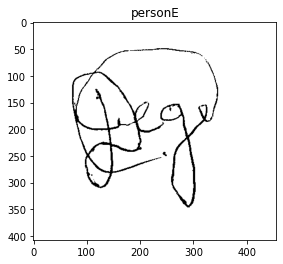

In [13]:
for each in predictions:
    plt.imshow(cv2.cvtColor(each['image'], cv2.COLOR_GRAY2RGB))
    plt.title(each['object_name'])
    plt.show()